# Apply Photometric Classification To Fit Results

This notebook applies the photometric classification method from González-Gaitán et al. 2014 to SDSS light-curve fit results.

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from astropy.table import Table
from bokeh.plotting import figure, output_notebook, show
from matplotlib import pyplot as plt
from scipy import optimize
from sklearn.utils import resample
from sndata.csp import dr1
from sndata.sdss import sako18

sys.path.insert(0, '..')
from phot_class import fom

output_notebook()
dr1.download_module_data()

# Output directory for figures
fig_dir = Path('./notebook_figs/classification')
fig_dir.mkdir(exist_ok=True, parents=True)


Loading BokehJS ...

## Load Data

We read in the SDSS classificaions for supernovae and join these with our own photometric classification parameters. We create seperate tables for the band-by-band and collective fit results.

In [2]:
# Read in sdss classifications
sdss_master = sako18.load_table('master')
sako_classification = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'spec_class': sdss_master['Classification']
})
sako_classification.set_index('obj_id', inplace=True)


In [3]:
def read_classification_data(path, sdss_classifications):
    # Read in our own classification data
    class_data = Table.read(path).to_pandas(index='obj_id')
    class_data['survey'] = 'SDSS'
    class_data['spec_class'] = 'Unspecified'

    # Update our table with sdss classifications
    class_data.update(sdss_classifications)
    return class_data


In [4]:
band_path = '../results/band_fits/with_ext/sdss_sako18_simple_fit_class.ecsv'
band_class = read_classification_data(band_path, sako_classification)

collective_path = '../results/collective_fits/with_ext/sdss_sako18_simple_fit_class.ecsv'
collective_class = read_classification_data(collective_path, sako_classification)
collective_class.head()


,x,y,survey,spec_class
obj_id,,,,
10028,-30.718333,-61.811193,SDSS,SNIa?
10036,0.266537,0.091667,SDSS,pSNIa
10037,-1.148080,-0.182717,SDSS,zSNIa
1008,-3.743340,-0.495803,SDSS,zSNIa
10096,-4.332436,0.309214,SDSS,SNIa


We also read in the actual fit results.

In [5]:
def read_fits_data(path):
    fits_data = Table.read(path).to_pandas()
    return fits_data.set_index(['source', 'obj_id'])


In [6]:
band_fits_path = '../results/band_fits/with_ext/sdss_sako18_simple_fit_fits.ecsv'
band_fits = read_fits_data(band_fits_path)
band_fits['band'] = [str(b)[-2] if b != 'all' else b for b in band_fits.band]

collective_fits_path = '../results/collective_fits/with_ext/sdss_sako18_simple_fit_fits.ecsv'
collective_fits = read_fits_data(collective_fits_path)
collective_fits.head(6)


/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'pre_max' from integer to float
  
/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'post_max' from integer to float
  
/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:6: TableReplaceWarning: converted column 'pre_max' from integer to float
  
/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:6: TableReplaceWarning: converted column 'post_max' from integer to float
  


message  band  pre_max  post_max  \
source   obj_id                                                               
hsiao_x1 10028   Minimization exited successfully.   all     85.0      20.0   
         10028   Minimization exited successfully.  blue     34.0       8.0   
         10028   Minimization exited successfully.   red     51.0      12.0   
sn91bg   10028   Minimization exited successfully.   all     90.0      15.0   
         10028   Minimization exited successfully.  blue     36.0       6.0   
         10028   Minimization exited successfully.   red     54.0       9.0   

                           vparams        x1         z             c  \
source   obj_id                                                        
hsiao_x1 10028     t0,amplitude,x1  0.141842  0.064256           NaN   
         10028        amplitude,x1  0.145950  0.064256           NaN   
         10028        amplitude,x1  0.097528  0.064256           NaN   
sn91bg   10028   t0,amplitude,x1,c  1.250000  0.064256  1.110223e-16   
         10028      amplitude,x1,c  1.250000  0.064256  3.878009e-13   
         10028      amplitude,x1,c  1.250000  0.064256  1.054712e-15   

                    amplitude            t0  ...    x1_err  z_err     c_err  \
source   obj_id                              ...                              
hsiao_x1 10028   2.190513e-04  2.453694e+06  ...  0.006493    NaN       NaN   
         10028   2.120666e-04  2.453694e+06  ...  0.007041    NaN       NaN   
         10028   2.255210e-04  2.453694e+06  ...  0.009118    NaN       NaN   
sn91bg   10028   1.127967e-15  2.453696e+06  ...  0.000311    NaN  0.000118   
         10028   1.811014e-15  2.453696e+06  ...  0.000986    NaN  0.005012   
         10028   9.607958e-16  2.453696e+06  ...  0.002071    NaN  0.001131   

                 amplitude_err    t0_err  mwebv_err    chisq  ndof  b_max  \
source   obj_id                                                             
hsiao_x1 10028    7.309902e-07  0.085901        NaN   412.58  32.0 -19.16   
         10028    8.540877e-07       NaN        NaN    37.06  12.0 -19.09   
         10028    7.930632e-07       NaN        NaN   155.41  19.0 -19.22   
sn91bg   10028    6.547090e-18  0.147287        NaN  4755.33  26.0 -18.52   
         10028    1.319683e-17       NaN        NaN   304.26   9.0 -19.04   
         10028    6.517304e-18       NaN        NaN  1049.86  15.0 -18.35   

                 delta_15  
source   obj_id            
hsiao_x1 10028      1.330  
         10028      1.339  
         10028      1.233  
sn91bg   10028      1.446  
         10028      1.446  
         10028      1.446  

[6 rows x 21 columns]

## Exploration of Failed Fits

We perform a cursory investigation of any fits that have failed to converge. To start, we note the unique error messages raised in the band and collective fit results.

In [7]:
def get_failed_fits(fits_df):
    failed_fits = fits_df['message'].str.lower().str.contains('failed')
    return fits_df[failed_fits]
    

In [8]:
print('Band fit error messages:\n')
print(get_failed_fits(band_fits).message.unique())

print('\nCollective fit error messages:\n')
print(get_failed_fits(collective_fits).message.unique())


Band fit error messages:

['No data points with S/N > 5.0. Initial guessing failed.'
 'Hesse Failed. Covariance may not be accurate. Covariance not positive definite.']

Collective fit error messages:

['No data points with S/N > 5.0. Initial guessing failed.'
 'Hesse Failed. Covariance may not be accurate. Covariance not positive definite.']


The SNR error is not concerning so long as there are an equal number of occurences between the band and collective fits.

In [9]:
snr_err_msg = 'No data points with S/N > 5.0. Initial guessing failed.'
band_snr_indices = band_fits.message == snr_err_msg
collective_snr_indices = collective_fits.message == snr_err_msg
equal_errors = sum(band_snr_indices) == sum(collective_snr_indices)

print('Equal Number of SNR errors:', equal_errors)


Equal Number of SNR errors: True


We drop the SNR errors for now and look at the distribution of the remaining errors across bands and models.

In [10]:
goodsnr_band_fits = band_fits[band_fits.message != snr_err_msg]
goodsnr_collective_fits = collective_fits[collective_fits.message != snr_err_msg]


In [11]:
band_failed_nosnr = get_failed_fits(goodsnr_band_fits)

print('Band by band error distribution\n')
print('By fitted band (set):')
print(band_failed_nosnr.band.str[-2].value_counts())

print('\nNumber of failed fits per source:')
print(band_failed_nosnr.droplevel(1).index.value_counts())

print('\nNumber of failed fits per object (num_failures number_targets):')
print(band_failed_nosnr.index.value_counts().value_counts())


Band by band error distribution

By fitted band (set):
Series([], Name: band, dtype: int64)

Number of failed fits per source:
hsiao_x1    193
Name: source, dtype: int64

Number of failed fits per object (num_failures number_targets):
1    179
2      7
dtype: int64


In [12]:
collective_failed_nosnr = get_failed_fits(goodsnr_collective_fits)

print('Collective error distribution\n')
print('By fitted band (set):')
print(collective_failed_nosnr.band.value_counts())

print('\nNumber of failed fits per source:')
print(collective_failed_nosnr.droplevel(1).index.value_counts())

print('\nNumber of failed fits per object (num_failures number_targets):')
print(collective_failed_nosnr.index.value_counts().value_counts())


Collective error distribution

By fitted band (set):
red    8
Name: band, dtype: int64

Number of failed fits per source:
hsiao_x1    8
Name: source, dtype: int64

Number of failed fits per object (num_failures number_targets):
1    8
dtype: int64


## Classification

We apply the classification to the fitted light curves.

In [13]:
def create_border_hist(axis, padding=0):
    """Create axes for plotting border histograms
    
    Args:
        axis     (Axis): The matplotlib axis to border
        padding (float): Spacing between the main and bordering axes
        
    Returns:
        Axis for the upper histogram
        Axis for the right side histogram
    """

    axis_pos = axis.get_position()
    axis_width = axis_pos.x1 - axis_pos.x0
    axis_height = axis_pos.y1 - axis_pos.y0

    histx_pos = axis.get_position()
    histx_pos.y0 += axis_height + padding
    histx_pos.y1 = histx_pos.y0 + .35 * axis_height + padding
    histx = plt.axes(histx_pos)
    histx.set_xlim(axis.get_xlim())
    histx.tick_params(direction='in', labelbottom=False)

    histy_pos = axis.get_position()
    histy_pos.x0 += axis_width + padding / 2
    histy_pos.x1 = histy_pos.x0 + .35 * axis_width + padding / 2
    histy = plt.axes(histy_pos)
    histy.set_ylim(axis.get_ylim())
    histy.tick_params(direction='in', labelleft=False)

    return histx, histy


def plot_classification(band_class, collective_class, fits_df, border_bins, padding):
    """Plot classification results
    
    Args:
        band_class       (DataFrame): Classification results from band fitting
        collective_class (DataFrame): Classification results from collective fitting
        fits_df          (DataFrame): DataFrame of fit results
        border_bins        (ndarray): Bins for histogram
        padding              (float): Spacing between the main and bordering axes
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot histogram of overall chi-squared values
    fits_hsiao = fits_df.loc['hsiao_x1']
    fits_hsiao = fits_hsiao[fits_hsiao.band == 'all']
    fits_sn91bg = fits_df.loc['sn91bg']
    fits_sn91bg = fits_sn91bg[fits_sn91bg.band == 'all']
    delta_chi = (fits_hsiao.chisq / fits_hsiao.ndof) - (fits_sn91bg.chisq / fits_sn91bg.ndof)

    chi_lt0 = delta_chi[delta_chi < 0]
    chi_gt0 = delta_chi[delta_chi > 0]

    bins = np.arange(-25, 25)
    axes[0].hist(chi_lt0, bins=bins, label=r'$\Delta \chi^2 < 0$ ({})'.format(len(chi_lt0)))
    axes[0].hist(chi_gt0, bins=bins, label=r'$\Delta \chi^2 > 0$ ({})'.format(len(chi_gt0)))
    axes[0].axvline(0, color='black', linestyle='--')
    axes[0].set_xlim(-10, 10)
    axes[0].set_title(r'$\Delta \chi^2$ (Hsiao - SN91bg)')
    axes[0].legend()

    # Plot collective fit results
    coll_class_lt = collective_class.loc[chi_lt0.index]
    coll_class_gt = collective_class.loc[chi_gt0.index]
    axes[1].scatter(coll_class_lt.x, coll_class_lt.y, s=10)
    axes[1].scatter(coll_class_gt.x, coll_class_gt.y, s=10)
    axes[1].axvline(0, color='grey', linestyle='--')
    axes[1].axhline(0, color='grey', linestyle='--')
    axes[1].set_xlim(-75, 75)
    axes[1].set_ylim(-50, 50)

    collective_histx, collective_histy = create_border_hist(axes[1], padding)
    collective_histx.hist([coll_class_lt.x , coll_class_gt.x], bins=border_bins, stacked=True)
    collective_histy.hist([coll_class_lt.y , coll_class_gt.y], bins=border_bins, stacked=True, orientation='horizontal')    
    collective_histx.set_xlim(axes[1].get_xlim())
    collective_histy.set_ylim(axes[1].get_ylim())
    collective_histy.set_title('Collective Fitting')
    collective_histx.set_yscale('log')
    collective_histy.set_xscale('log')

    # Plot band-by-band fit results
    ax2_pos = axes[2].get_position()
    width = ax2_pos.x1 - ax2_pos.x0
    ax2_pos.x0 += .4 * width
    ax2_pos.x1 += .4 * width
    axes[2].set_position(ax2_pos)

    band_class_lt = band_class.loc[chi_lt0.index]
    band_class_gt = band_class.loc[chi_gt0.index]
    axes[2].scatter(band_class_lt.x, band_class_lt.y, s=10)
    axes[2].scatter(band_class_gt.x, band_class_gt.y, s=10)
    axes[2].axvline(0, color='grey', linestyle='--')
    axes[2].axhline(0, color='grey', linestyle='--')
    axes[2].set_xlim(-75, 75)
    axes[2].set_ylim(-50, 50)

    band_histx, band_histy = create_border_hist(axes[2], padding)
    band_histx.hist([band_class_lt.x , band_class_gt.x], bins=border_bins, stacked=True)
    band_histy.hist([band_class_lt.y , band_class_gt.y], bins=border_bins, stacked=True, orientation='horizontal')
    band_histx.set_xlim(axes[2].get_xlim())
    band_histy.set_ylim(axes[2].get_ylim())
    band_histy.set_title('Band Fitting')
    band_histx.set_yscale('log')
    band_histy.set_xscale('log')


/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata

<Figure size 432x288 with 0 Axes>

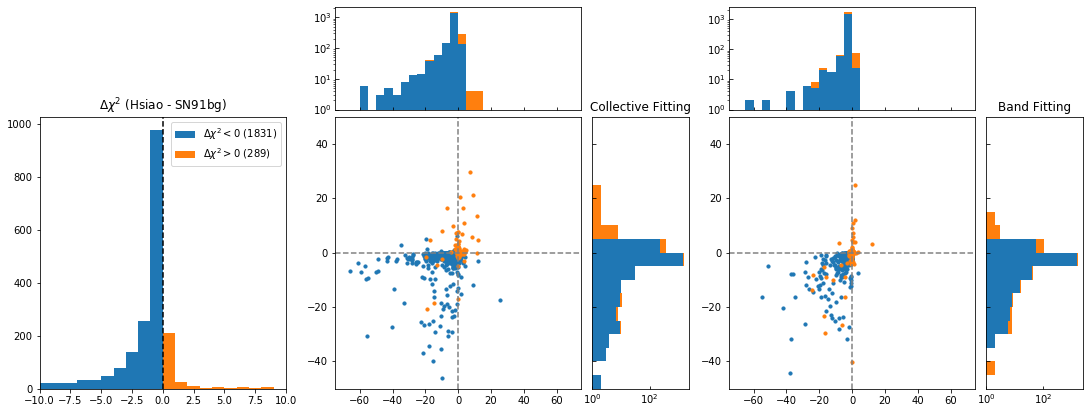

In [14]:
plt.tight_layout()
plot_classification(band_class, collective_class, band_fits, np.arange(-100, 100, 5), .02)
plt.savefig(fig_dir / 'classification.pdf')


## Intrinsic Properties

We consider the distribution of fit parameters.

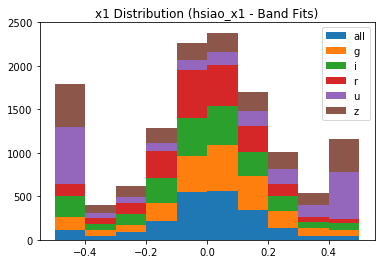

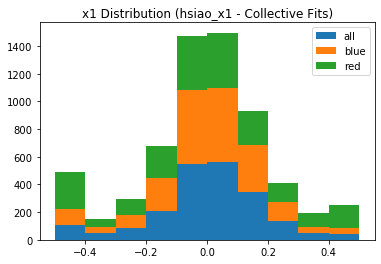

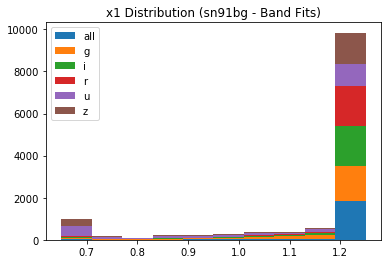

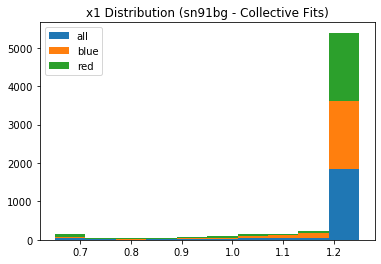

In [15]:
for source in ('hsiao_x1', 'sn91bg'):
    for df, fit_type in zip((band_fits.loc[source], collective_fits.loc[source]), ('Band', 'Collective')):
        labels, data = np.transpose([[band, band_data.x1] for band, band_data in df.groupby('band')])
        plt.hist(data, stacked=True, label=labels)
        plt.title(f'x1 Distribution ({source} - {fit_type} Fits)')
        plt.legend()
        
        plt.savefig(fig_dir / f'x1_distribution_{source}_{fit_type}_fits.pdf'.lower())
        plt.show()
    

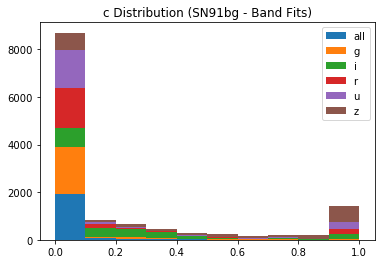

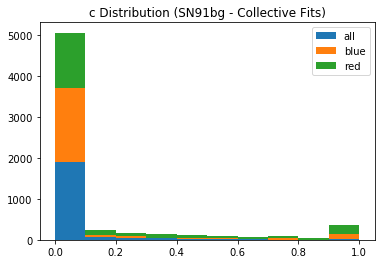

In [16]:
for df, fit_type in zip((band_fits.loc['sn91bg'], collective_fits.loc['sn91bg']), ('Band', 'Collective')):
    labels, data = np.transpose([[band, band_data.c] for band, band_data in df.groupby('band')])
    plt.hist(data, stacked=True, label=labels)
    plt.title(f'c Distribution (SN91bg - {fit_type} Fits)')
    plt.legend()
    
    plt.savefig(fig_dir / f'c_distribution_sn91bg_{fit_type}_fits.pdf'.lower())
    plt.show()


Text(0, 0.5, 'Color (c)')

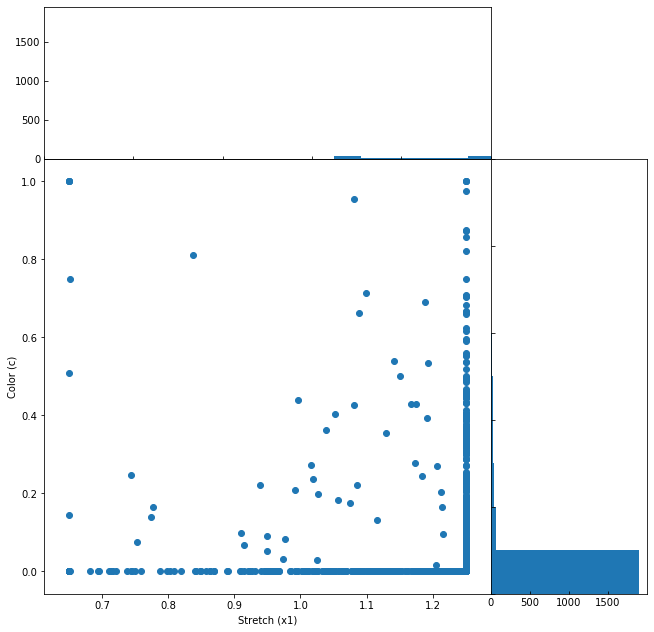

In [17]:
band_fits_all = band_fits[band_fits.band == 'all']
collective_fits_all = collective_fits[collective_fits.band == 'all']

fig, axis = plt.subplots(1, 1, figsize=(8, 8))
histx, histy = create_border_hist(axis)

axis.scatter(band_fits_all.loc['sn91bg'].x1, band_fits_all.loc['sn91bg'].c)
histx.hist(band_fits_all.loc['sn91bg'].x1)
histy.hist(band_fits_all.loc['sn91bg'].c, orientation='horizontal')   

axis.set_xlabel('Stretch (x1)')
axis.set_ylabel('Color (c)')


Text(0, 0.5, 'Hsiao Stretch (x1)')

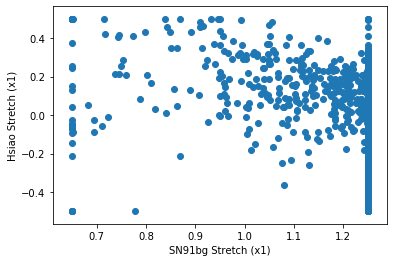

In [18]:
plt.scatter(band_fits_all.loc['sn91bg'].x1, band_fits_all.loc['hsiao_x1'].x1)
plt.xlabel('SN91bg Stretch (x1)')
plt.ylabel('Hsiao Stretch (x1)')

## Host Galaxy Properties

We start with some book keeping, and create dataframes for various subsets of the host galaxy data.

In [19]:
host_photometry = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'host_id': sdss_master['objIDHost'],  # Host galaxy object ID in SDSS DR8 Database 
    'ra': sdss_master['RAhost'],  # Right ascension of galaxy host (degrees) 
    'dec': sdss_master['DEChost'],  # Declination of galaxy host (degrees) 
    'dist': sdss_master['separationhost'], # Distance from SN to host (arcsec) 
    'distnorm': sdss_master['DLRhost'], # Normalized distance from SN to host (dDLR) 
    'z_KF': sdss_master['zphothost'], # Host photometric redshift (KF algorithm) 
    'z_KF_err': sdss_master['zphoterrhost'], # zphothost uncertainty
    'z_RF': sdss_master['zphotRFhost'],  # Host photometric redshift (RF algorithm) 
    'z_RF_err': sdss_master['zphotRFerrhost'],  # zphotRFhost uncertainty 
    'u_mag': sdss_master['dereduhost'],  # Host galaxy u-band magnitude (dereddened) 
    'u_mag_err': sdss_master['erruhost'], # Host galaxy u-band magnitude uncertainty 
    'g_mag': sdss_master['deredghost'],  # Host galaxy g-band magnitude (dereddened)
    'g_mag_err': sdss_master['errghost'],  #  Host galaxy g-band magnitude uncertainty 
    'r_mag': sdss_master['deredrhost'],  # Host galaxy r-band magnitude (dereddened)
    'r_mag_err': sdss_master['errrhost'],  #  Host galaxy r-band magnitude uncertainty 
    'i_mag': sdss_master['deredihost'], # Host galaxy i-band magnitude (dereddened) 
    'i_mag_err': sdss_master['errihost'], # Host galaxy i-band magnitude uncertainty 
    'z_mag': sdss_master['deredzhost'], # Host galaxy z-band magnitude (dereddened) 
    'z_mag_err': sdss_master['errzhost'] # Host galaxy z-band magnitude (dereddened)
})
host_photometry.set_index('obj_id', inplace=True)
    
# Galaxy Parameters Calculated with FPPS
fpps_params = pd.DataFrame({
    'obj_id' : sdss_master['CID'],
    'logmass' : sdss_master['logMassFSPS'],  # FSPS log(M), M=Galaxy Mass (M in units of Me)
    'logmass_lo' : sdss_master['logMassloFSPS'],  # FSPS Lower limit of uncertainty in log(M)
    'logmass_hi' : sdss_master['logMasshiFSPS'],  # FSPS Upper limit of uncertainty in log(M)
    'logssfr' : sdss_master['logSSFRFSPS'],  # FSPS log(sSFR) sSFR=Galaxy Specific Star-forming Rate (SFR in Me yr−1)
    'logssfr_lo' : sdss_master['logSSFRloFSPS'],  # FSPS Lower limit of uncertainty in log(sSFR)
    'logssfr_hi' : sdss_master['logSSFRhiFSPS'],  # FSPS Upper limit of uncertainty in log(sSFR)
    'age' : sdss_master['ageFSPS'],  # FSPS galaxy age (Gyr)
    'age_lo' : sdss_master['ageloFSPS'],  # FSPS Lower limit of uncertainty in age
    'age_hi' : sdss_master['agehiFSPS'],  # FSPS Upper limit of uncertainty in age 
    'rchisq' : sdss_master['minredchi2FSPS'] # Reduced chi-squared of best FSPS template fit
})
fpps_params.set_index('obj_id', inplace=True)

# Galaxy Parameters Calculated with PÉGASE.2
pegase_params = pd.DataFrame({
    'obj_id' : sdss_master['CID'],
    'logmass' : sdss_master['logMassPEGASE'], # PÉGASE.2 log(M), M=Galaxy Mass (M in units of Me) 
    'logmass_lo' : sdss_master['logMassloPEGASE'], # PÉGASE.2 Lower limit of uncertainty in log(M)
    'logmass_hi' : sdss_master['logMasshiPEGASE'], # PÉGASE.2 Upper limit of uncertainty in log(SFR) 
    'logssfr' : sdss_master['logSFRPEGASE'], # PÉGASE.2 log(SFR) SFR=Galaxy star-forming rate (Me yr−1)
    'logssfr_lo' : sdss_master['logSFRloPEGASE'], # PÉGASE.2 Lower limit of uncertainty in log(SFR)
    'logssfr_hi' : sdss_master['logSFRhiPEGASE'], # PÉGASE.2 Upper limit of uncertainty in log(SFR)
    'age' : sdss_master['agePEGASE'], # PÉGASE.2 galaxy age (Gyr)
    'rchisq' : sdss_master['minchi2PEGASE']# Reduced chi-squared of best PÉGASE.2 fit
})
pegase_params.set_index('obj_id', inplace=True)


Next we define a few plotting functions to help simplify our work later on.

In [20]:
def plot_host_property_distribution(col_name, bg_ids, normal_ids, *data_frames, **kwargs):
    """Plot histograms of host galaxy properties
    
    Args:
    col_name     (str): The name of the value to plot
    bg_ids     (Series): Object Ids of 91bg like SN
    normal_ids (Series): Object Ids of normal SN
    *data_frames (DataFrame): Data frames with host galaxy data

    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    fig, axes = plt.subplots(1, len(data_frames), sharex=True, sharey=True)
    if len(data_frames) == 1:
        axes = np.array([axes])
    
    for df, axis in zip(data_frames, axes.flatten()):
        plot_data = df[col_name][df[col_name] > 0]
        bg_data = plot_data.reindex(bg_ids).dropna()
        normal_data = plot_data.reindex(normal_ids).dropna()
        stat = stats.anderson_ksamp([bg_data, normal_data])
        print(stat, '\n')
        
        axis.hist(normal_data, label=f'Normal ({len(normal_data)})', density=True, **kwargs)
        axis.hist(bg_data, fill=False, 
                  hatch='///', density=True, 
                  histtype='step', label=f'91bg ({len(bg_data)})',
                  **kwargs)

    axes[-1].legend()
    plt.tight_layout()
    return fig, axes
        

NameError: name 'stats' is not defined

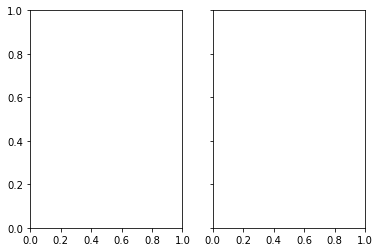

In [21]:
for df, fitting_type in zip((band_class, collective_class), ('Band Fits', 'Collective Fits')):
    bg_like = df[(df.x > 0) & (df.y > 0)].index
    normal = df[(df.x < 0) & (df.y < 0)].index

    fig, axes = plot_host_property_distribution('logmass', bg_like, normal, fpps_params, pegase_params) 
    axes[0].set_title(f'FPPS')
    axes[1].set_title(f'PEGASE')
    for axis in axes:
        axis.set_xlabel(r'$\log(M)$')

    file_name = '_'.join(title.split()).lower() + '_mass.pdf'
    plt.tight_layout()
    plt.savefig(fig_dir / file_name)
    
    print(fitting_type)
    plt.show()


In [ ]:
for df, title in zip((band_class, collective_class), ('Band Fits', 'Collective Fits')):
    bg_like = df[(df.x > 0) & (df.y > 0)].index
    normal = df[(df.x < 0) & (df.y < 0)].index

    fig, axes = plot_host_property_distribution('logssfr', bg_like, normal, pegase_params) 
    axes[0].set_title(f'PEGASE ({title})')
    for axis in axes:
        axis.set_xlabel(r'$\log(SSFR)$')
    
    file_name = '_'.join(title.split()).lower() + '_ssfr.pdf'
    plt.tight_layout()
    plt.savefig(fig_dir / file_name)
    plt.show()


In [ ]:
for df, title in zip((band_class, collective_class), ('Band Fits', 'Collective Fits')):
    fig, axes = plot_host_property_distribution(
        'dist', bg_like, normal, host_photometry, bins = np.arange(0, 40)) 

    axes[0].set_xlabel('Distance (arcsec) ')
    axes[0].set_title(f'Distance from SN to host (arcsec) ({title})')
    
    file_name = '_'.join(title.split()).lower() + '_distance.pdf'
    plt.tight_layout()
    plt.savefig(fig_dir / file_name)
    plt.show()